# Initial Setup

In [1]:
import os
import numpy as np
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import keras_export

print(tf.__version__)

2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Imagenet Subset 

In [3]:
dataDir = '/data/datasets/cifar100/raw'

configDir = 'config'
resultsDir = 'results'
modelsDir = 'saved_models/cifar100_efficientnet_Adam_v1'
logsDir = 'logs/cifar100_efficientnet_Adam_v1'

In [4]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
LOG_STEPS = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE

NUM_CLASSES = 100
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3

IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [5]:
if not os.path.exists(configDir):
  os.makedirs(configDir)

if not os.path.exists(resultsDir):
  os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
  os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
  os.makedirs(logsDir)

In [6]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    cifar_dict = pickle.load(fo, encoding='bytes')
  return cifar_dict

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

In [7]:
def rotate_zoom_tf(image, angle, zoom):

  angleRad = angle/180.*np.pi

  if image.shape.__len__() ==4:
    random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
    random_zoom = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 1-zoom, maxval = 1+zoom)
  if image.shape.__len__() ==3:
    random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)
    random_zoom = tf.random.uniform(shape = (), minval = 1-zoom, maxval = 1+zoom)

  paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
  img = tf.pad(image, paddings, "SYMMETRIC")
  img = tfa.image.rotate(img, random_angles)
  img = tf.image.resize_with_crop_or_pad(img, int(IMG_HEIGHT*random_zoom), int(IMG_WIDTH*random_zoom))
  img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)

  return img

def rotate_tf(image, angle):
  angleRad = angle/180.*np.pi

  if image.shape.__len__() ==4:   
    random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = -angleRad, maxval = angleRad)
  if image.shape.__len__() ==3:
    random_angles = tf.random.uniform(shape = (), minval = -angleRad, maxval = angleRad)

  paddings = tf.constant([[int(IMG_HEIGHT/4), int(IMG_HEIGHT/4)], [int(IMG_WIDTH/4), int(IMG_WIDTH/4)], [0,0]])
  img = tf.pad(image, paddings, "SYMMETRIC")
  img = tfa.image.rotate(img, random_angles)
  img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT, IMG_WIDTH)

  return img

def augment(image, label):
  #img = tf.image.rot90(image)
  img = tf.image.flip_left_right(image)
  #img = rotate_tf(image, 20)
  img = rotate_zoom_tf(image, 20, 0.2)
  #img = tf.image.random_brightness(img, 0.05)
  #img = tf.image.random_contrast(img, 0.9, 1.1)
  img = tf.clip_by_value(img, 0.0, 1.0)

  return (img, label)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [8]:
meta = unpickle(os.path.join(dataDir, 'meta'))
train = unpickle(os.path.join(dataDir, 'train'))
test = unpickle(os.path.join(dataDir, 'test'))

In [9]:
classDF = pd.DataFrame(meta[b'fine_label_names'], columns = ['Classes'], dtype=str)
CLASS_NAMES = np.array(classDF['Classes'])

In [10]:
trainX = np.vstack(train[b"data"])
trainX = trainX.reshape(len(trainX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
trainY = np.array(train[b'fine_labels'])
trainY = tf.one_hot(trainY, NUM_CLASSES)

testX = np.vstack(test[b"data"])
testX = testX.reshape(len(testX), NUM_CHANNELS, IMG_HEIGHT, IMG_WIDTH).transpose(0,2,3,1).astype("float32")/255
testY = np.array(test[b'fine_labels'])#.reshape(-1,1)
testY = tf.one_hot(testY, NUM_CLASSES)

In [11]:
print("Train dataset numpy array")
print(trainX.shape)
print(trainY.shape)

print("\nValidation dataset numpy array")
print(testX.shape)
print(testY.shape)

Train dataset numpy array
(50000, 32, 32, 3)
(50000, 100)

Validation dataset numpy array
(10000, 32, 32, 3)
(10000, 100)


In [12]:
TRAIN_EXAMPLES = trainX.shape[0]
VAL_EXAMPLES = testX.shape[0]

TRAIN_STEPS = TRAIN_EXAMPLES//BATCH_SIZE
VAL_STEPS = VAL_EXAMPLES//BATCH_SIZE

In [13]:
trainLabelDS = tf.data.Dataset.from_tensor_slices((trainX, trainY))
valLabelDS = tf.data.Dataset.from_tensor_slices((testX, testY))

In [14]:
trainDS = prepare_for_training(trainLabelDS)
valDS = prepare_for_validation(valLabelDS)

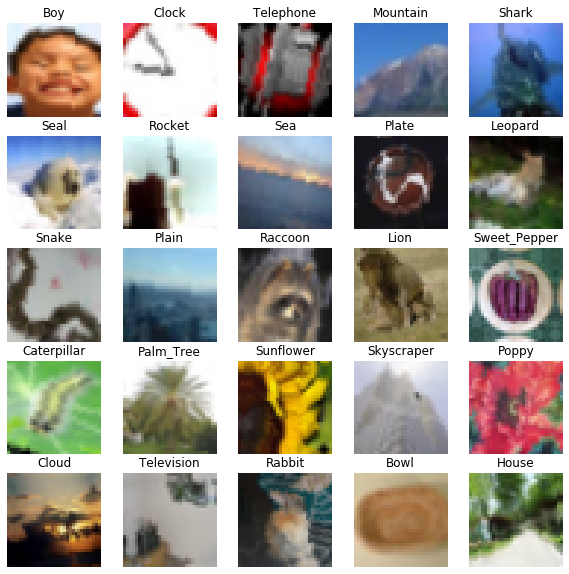

In [15]:
image_batch, label_batch = next(iter(trainDS))
show_batch(image_batch.numpy(), label_batch.numpy())

## Create model

In [24]:
import efficientnet.tfkeras as efn

modelDiagramFile = os.path.join(resultsDir, 'model_efficientnet_cifar100_v1.png')

base_model = efn.EfficientNetB0(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), weights=None, include_top=False)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

#keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)
#model.summary()

## Train model

In [25]:
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

In [28]:
loss_obj = tf.keras.losses.CategoricalCrossentropy(
          label_smoothing=0.)

In [29]:
metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
         tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]

In [30]:
model.compile(optimizer=optimizer,
              loss=loss_obj,
              metrics=metrics)

In [31]:
# Hack to log learning rate in Tensorboard

class TensorBoard(tf.keras.callbacks.TensorBoard):
    def _collect_learning_rate(self, logs):
        logs = logs or {}
        lr_schedule = getattr(self.model.optimizer, "lr", None)
        if isinstance(lr_schedule, tf.keras.optimizers.schedules.LearningRateSchedule):
            logs["learning_rate"] = tf.keras.backend.get_value(
                lr_schedule(self.model.optimizer.iterations)
            )
        return logs

    def _log_metrics(self, logs, prefix, step):
        super()._log_metrics(self._collect_learning_rate(logs), prefix, step)

In [32]:
from utils.keras_utils import TimeHistory

logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = TensorBoard(log_dir=logsCheckDir, histogram_freq=1)

perf_callback = TimeHistory(BATCH_SIZE,
                            LOG_STEPS,
                            logdir=logsCheckDir+'/metrics')

callbacks = [tb_callback, perf_callback]

In [ ]:
startTime = time.time()

model.fit(trainDS,
          epochs=NUM_EPOCHS,
          steps_per_epoch=TRAIN_STEPS,
          initial_epoch=0,
          callbacks=callbacks,
          validation_data=valDS,
          validation_steps=VAL_STEPS,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Epoch 1/100
  2/781 [..............................] - ETA: 4:11 - loss: 4.9532 - accuracy: 0.0078 - top_5_accuracy: 0.0312  WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.309780). Check your callbacks.


781/781 [==============================] - 27s 35ms/step - loss: 4.3402 - accuracy: 0.0481 - top_5_accuracy: 0.1870 - val_loss: 4.0153 - val_accuracy: 0.0814 - val_top_5_accuracy: 0.2806
Epoch 2/100
781/781 [==============================] - 25s 32ms/step - loss: 3.9257 - accuracy: 0.0943 - top_5_accuracy: 0.3063 - val_loss: 4.2362 - val_accuracy: 0.1172 - val_top_5_accuracy: 0.3670
Epoch 3/100
781/781 [==============================] - 25s 32ms/step - loss: 3.6839 - accuracy: 0.1291 - top_5_accuracy: 0.3779 - val_loss: 3.6839 - val_accuracy: 0.1491 - val_top_5_accuracy: 0.4085
Epoch 4/100
781/781 [==============================] - 25s 33ms/step - loss: 3.5466 - accuracy: 0.1542 - top_5_accuracy: 0.4153 - val_loss: 3.4321 - val_accuracy: 0.1875 - val_top_5_accuracy: 0.4750
Epoch 5/100
781/781 [==============================] - 25s 32ms/step - loss: 3.3895 - accuracy: 0.1794 - top_5_accuracy: 0.4601 - val_loss: 4.2899 - val_accuracy: 0.1655 - val_top_5_accuracy: 0.4181
Epoch 6/100
781/7

## Save model

In [ ]:
modelFile = os.path.join(modelsDir, 'model_densenet169.h5')

model.save(modelFile)

## Plot confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
y_pred=np.argmax(model.predict(testX), axis=1)
y_true=np.argmax(testY, axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=CLASS_NAMES,
                      title='Confusion matrix, without normalization')